In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import directlfq.lfq_manager as lfq_manager
import scipy.stats as stat
from sklearn.decomposition import PCA 

In [78]:
# general settings
fontsize = 16
lw = 2
na_perc = 0.7
props = dict(boxstyle='round, pad=0.5', facecolor='white', edgecolor='k', 
             linewidth=2, mutation_aspect=0.8, pad=0.3)

blues = sns.color_palette('Blues', 20)
greens = sns.color_palette('Greens', 5)
oranges = sns.color_palette('Oranges', 5)

colors = [blues[1], blues[13]]
colors2 = [blues[10], blues[18]]

cmap = 'viridis_r'
cmap2 = 'RdBu_r'

gamma = '\u03B3'
interferon = 'IFN-' + gamma

labels = ['Control', interferon]
names = ['MBR', 'DIA-ME']

In [79]:
path = '01_Data/01_Reports/'

reports = []
for i in range(2):
    reports.append(pd.read_csv(path + names[i] + '_report.tsv', sep='\t'))

In [80]:
path2 = '01_Data/02_Filtered_Reports/'

for i, frame in enumerate(reports):
    
    frame = frame[frame['Q.Value'] <= 0.01]
    frame = frame[frame['Lib.Q.Value'] <= 0.01]
    frame = frame[frame['Lib.PG.Q.Value'] <= 0.01]

    reports[i] = frame[~frame['Run'].str.contains('_10SC_')]  # removing MEs
    reports[i].to_csv(path2 + 'f_' + names[i] + '_report.tsv', sep='\t')

    lfq_manager.run_lfq(path2 + 'f_' + names[i] + '_report.tsv')  # directLFQ normalization
# #     Manual transfer to '01_Data/03_DirectLFQ_Quan/'

In [81]:
path3 = '01_Data/03_DirectLFQ_Quan/'

prot_frames = []
quans = []
for name in names:
    frame = pd.read_csv(path3 + 'f_' + name + '_report.tsv.protein_intensities.tsv', sep='\t')
    frame.replace(0, np.nan, inplace=True)
    prot_frames.append(frame)
    
    quan_cols = [c for c in frame if '_KK_' in c]
    quans.append(frame[['Protein.Group', 'Genes'] + quan_cols].set_index(['Protein.Group', 'Genes']))
    
pep_frames = []
for name in names:
    frame = pd.read_csv(path3 + 'f_' + name + '_report.tsv.diann_precursors.aq_reformat.tsv', sep='\t')
    frame.replace(0, np.nan, inplace=True)
    pep_frames.append(frame)
    

C:\Users\k689l\AppData\Local\Temp\ipykernel_10504\671430122.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, weight='bold')
E:\KK\03_Programs\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.canvas.print_figure(bytes_io, **kw)
E:\KK\03_Programs\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.canvas.print_figure(bytes_io, **kw)


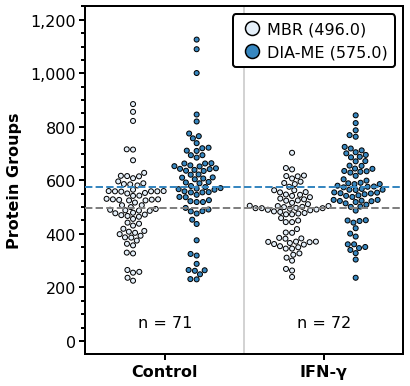

In [82]:
counts = pd.DataFrame()
totals = pd.DataFrame()

for i, frame in enumerate(quans):
    counts[names[i]] = frame.count()
    totals[names[i]] = [len(frame)]

counts = counts.melt(ignore_index=False)
counts['Treatment'] = [i.split('_')[3] for i in counts.index]

fig, ax = plt.subplots(1, 1, figsize=(5.7,6.4))

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)

sns.swarmplot(data=counts, y='value', x='Treatment', order=['control', 'IFNy'], hue='variable', 
              size=5, dodge=True, edgecolor='black', linewidth=lw/2, palette=colors, ax=ax)

ax.set_ylim([-50, 1250])
ax.set_ylabel('Protein Groups', fontsize=fontsize, fontweight='bold', labelpad=8)
ax.set_xlabel('')

ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=lw*3, width=lw, labelsize=fontsize)
ax.tick_params(axis='x', which='minor', length=0)
ax.tick_params(axis='y', which='minor', length=lw*2, width=lw)
ax.set_xticklabels(labels, weight='bold')

ax.axvline(x=0.5, color='lightgrey', linewidth=lw)

reps = counts['Treatment'].value_counts() / 2
handles = []
for i in range(2):
    ax.text(i, 50, 'n = ' + str(int(reps[i-1])), ha='center', fontsize=fontsize, color='k')
    
    median = counts[counts['variable'] == names[i]]['value'].median()
    ax.axhline(y=median, linestyle='dashed', color=['grey', blues[13]][i], lw=lw, zorder=5)
    
    handle_text = names[i] + ' (' + str(round(median, 0)) + ')'
    handles.append(mpl.lines.Line2D([0],[0], lw=0, marker='o', color='k', label=handle_text, 
                                    markerfacecolor=colors[i], markersize=14, markeredgewidth=1.5))

legend = ax.legend(handles=handles, fontsize=fontsize, handlelength=1.5, handleheight=0.5, handletextpad=0.2, 
                   edgecolor='k', framealpha=1, borderpad=0.45, loc=0)
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/SC_IFN_ProteinGroups_Swarmplot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_ProteinGroups_Swarmplot.pdf', dpi=400, bbox_inches='tight') 

C:\Users\k689l\AppData\Local\Temp\ipykernel_10504\2963763068.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(names, fontweight='bold', rotation=40, rotation_mode='anchor', ha='right')


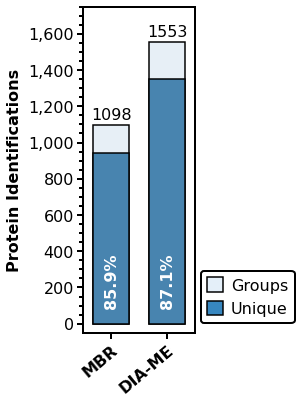

In [83]:
d = {'Experiment': names, 'Total': [totals[names[0]][0], totals[names[1]][0]], 
     'Groups': [len(quans[0][quans[0].index.get_level_values(0).str.contains(';')]), 
                len(quans[1][quans[1].index.get_level_values(0).str.contains(';')])],
     'Unique': [len(quans[0][~quans[0].index.get_level_values(0).str.contains(';')]), 
                len(quans[1][~quans[1].index.get_level_values(0).str.contains(';')])]}
total = pd.DataFrame(d)
total['Perc'] = total['Unique'] / total['Total'] *100

fig, ax = plt.subplots(1,1, figsize=(2,6))

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)
    
sns.barplot(data=total, x='Experiment', y='Total', color=colors[0], edgecolor='k', 
            linewidth=lw-0.5, width=0.65, ax=ax)
sns.barplot(data=total, x='Experiment', y='Unique', color=colors[1], edgecolor='k', 
            linewidth=lw-0.5, width=0.65, ax=ax)

ax.set_ylabel('Protein Identifications', fontsize=fontsize, fontweight='bold', labelpad=6)
ax.set_xlabel('')

ax.set_ylim([-50, 1750])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=lw*3, width=lw, labelsize=fontsize)
ax.tick_params(axis='x', which='minor', length=0)
ax.tick_params(axis='y', which='minor', length=lw*2, width=lw)
ax.set_xticklabels(names, fontweight='bold', rotation=40, rotation_mode='anchor', ha='right')

handles = []
for i in range(2):
    value = totals[names[i]][0]
    uni_perc = round(total['Perc'][i],1)
    ax.text(x=i, y=value+30, s=str(value), fontsize=fontsize, color='k', ha='center')
    ax.text(x=i, y=100, s=str(uni_perc) + '%', rotation=90, fontsize=fontsize, color='white', weight='bold', ha='center')
    
    handles.append(mpl.patches.Patch(facecolor=colors[i], edgecolor='k', alpha=1, linewidth=lw-0.5))
    
legend = ax.legend(handles=handles, labels=['Groups', 'Unique'], handlelength=1, handleheight=1, handletextpad=0.5, 
                   borderaxespad=0.3, fontsize=fontsize, framealpha=1, edgecolor='k', loc=(1.05,0.03))
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/SC_IFN_ProteinGroups_Total_Barplot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_ProteinGroups_Total_Barplot.pdf', dpi=400, bbox_inches='tight') 

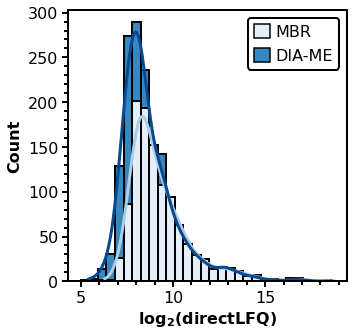

In [84]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)

handles = []
for i, frame in enumerate(quans):
    medians = np.log2(frame).median(axis=1)
    
    sns.histplot(data=medians, color=colors[i], linewidth=lw, binrange=[5,18], bins=28, 
                 kde=True, alpha=1, ax=ax, zorder=-1*i, line_kws={'lw': lw+1})
    
    handles.append(mpl.patches.Patch(facecolor=colors[i], edgecolor='k', lw=lw-0.5, label=names[i]))
    
ax.lines[0].set_color(blues[6])
ax.lines[1].set_color(blues[18])

ax.set_ylabel('Count', fontsize=fontsize, fontweight='bold', labelpad=6)
ax.set_xlabel('log'+r'$\bf{_{2}}$'+'(directLFQ)', fontsize=fontsize, fontweight='bold')

ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=lw*3, width=lw, labelsize=fontsize)
ax.tick_params(axis='both', which='minor', length=lw*2, width=lw)

legend = ax.legend(handles=handles, fontsize=fontsize, handlelength=1,  handleheight=1,
                   handletextpad=0.3, edgecolor='k', framealpha=1, loc=0)
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/SC_IFN_ProteinGroups_Histogram.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_ProteinGroups_Histogram.pdf', dpi=400, bbox_inches='tight') 

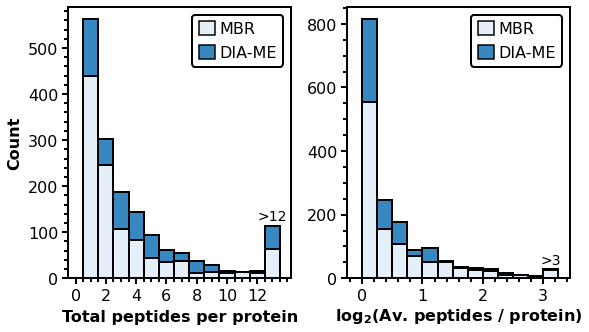

In [85]:
pep_quans = []
pep_per_prot_counts = []
for i, frame in enumerate(pep_frames):
    pep_quan = pep_frames[i].set_index('protein')
    pep_quans.append(pep_quan)
    
    pep_per_prot_count = pep_quan.groupby(pep_quan.index).count().replace(0, np.nan).rename(columns={'ion': 'Pep sum'})
    pep_per_prot_count['Mean'] = pep_per_prot_count[quan_cols].mean(axis=1).replace(0, np.nan)
    pep_per_prot_counts.append(pep_per_prot_count.drop(columns=quan_cols))

fig, ax = plt.subplots(1,2, figsize=(9,5))
plt.subplots_adjust(wspace=0.25)
axs = fig.axes

thresh = 12
thresh2 = 3
handles = []
for i in range(2):
    
    for axis in ['top', 'bottom', 'left', 'right']:
        axs[i].spines[axis].set_linewidth(lw)

#     left plot
    data = pep_per_prot_counts[i][pep_per_prot_counts[i]['Pep sum'] <= thresh]
    sns.histplot(data=data, x='Pep sum', color=colors[i], binrange=[0, thresh], bins=thresh, discrete=True, 
                 linewidth=lw, edgecolor='k', alpha=1, ax=axs[0], zorder=-1*i)
    
    thresh_data = pep_per_prot_counts[i][pep_per_prot_counts[i]['Pep sum'] > thresh]
    axs[0].bar(x=thresh+1, height=len(thresh_data), width=1, color=colors[i], linewidth=lw, edgecolor='k', zorder=-1*i)
    
#     right plot
    data2  = np.log2(pep_per_prot_counts[i])
    sns.histplot(data=data2, x='Mean', color=colors[i], binrange=[0, thresh2], bins=thresh2*4, 
                 linewidth=lw, edgecolor='k', alpha=1, ax=axs[1], zorder=-1*i)
    thresh_data2 = data2[data2['Mean'] > thresh2]
    axs[1].bar(x=thresh2+0.125, height=len(thresh_data2), width=0.25, color=colors[i], 
               linewidth=lw, edgecolor='k', zorder=-1*i)

    handles.append(mpl.patches.Patch(facecolor=colors[i], edgecolor='k', lw=lw-0.5, label=names[i]))
    
    axs[i].minorticks_on()
    axs[i].tick_params(axis='both', which='major', length=lw*3, width=lw, labelsize=fontsize)
    axs[i].tick_params(axis='both', which='minor', length=lw*2, width=lw)
    
# left plot
axs[0].set_xlim([-0.5, thresh + 2.25])
axs[0].set_xticks(range(0,14,2))

axs[0].set_ylabel('Count', fontsize=fontsize, fontweight='bold', labelpad=6)
axs[0].set_xlabel('Total peptides per protein', fontsize=fontsize, fontweight='bold', labelpad=6)

axs[0].text(x=thresh + 1, y=len(thresh_data)*1.1, s='>'+str(thresh), fontsize=fontsize-2, ha='center')

legend = axs[0].legend(handles=handles, fontsize=fontsize, handlelength=1, handleheight=1, handletextpad=0.3, 
                       edgecolor='k', framealpha=1, loc=0)
legend.get_frame().set_linewidth(lw)

# right plot
axs[1].set_xlim([-0.25, thresh2 + 0.45])
axs[1].set_xticks(range(0,4,1))

axs[1].set_ylabel('')
axs[1].set_xlabel('log'+r'$\bf{_{2}}$'+'(Av. peptides / protein)', fontsize=fontsize, fontweight='bold', labelpad=3)

axs[1].text(x=thresh2 + 0.125, y=len(thresh_data2)*1.5, s='>'+str(thresh2), fontsize=fontsize-2, ha='center')

legend = axs[1].legend(handles=handles, fontsize=fontsize, handlelength=1, handleheight=1, handletextpad=0.3, 
                       edgecolor='k', framealpha=1, loc=0)
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/SC_IFN_Peptides_Histograms.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_Peptides_Histograms.pdf', dpi=400, bbox_inches='tight') 

Text(0.5, 1.0, 'Ratio')

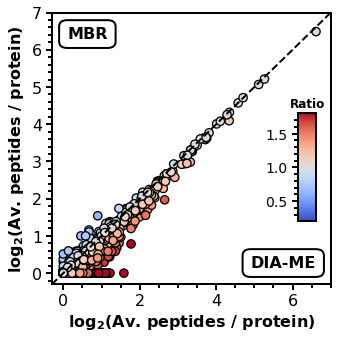

In [86]:
merge_counts = pep_per_prot_counts[0].merge(pep_per_prot_counts[1], how='outer', left_index=True, right_index=True)
merge_counts['Ratio'] = 2**(merge_counts['Mean_y'] / merge_counts['Mean_x'])
merge_counts = np.log2(merge_counts)

vmin = 0.2
vmax = 1.8
fig, ax = plt.subplots(1,1, figsize=(5,5))

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)
        
sns.scatterplot(data=merge_counts, x='Mean_y', y='Mean_x', hue='Ratio', palette='coolwarm', hue_norm=(vmin, vmax),
                edgecolor='k', s=70, linewidth=1.3, alpha=1, ax=ax)
ax.axline((0,0), (10,10), color='k', linestyle='dashed', lw=lw)

ax.set_xlim(-0.3, 7)
ax.set_ylim(-0.3, 7)

ax.set_ylabel('log'+r'$\bf{_{2}}$'+'(Av. peptides / protein)', fontsize=fontsize, weight='bold', labelpad=6)
ax.set_xlabel('log'+r'$\bf{_{2}}$'+'(Av. peptides / protein)', fontsize=fontsize, weight='bold', labelpad=4)
ax.legend().remove()

ax.minorticks_on()
ax.tick_params(axis='both', which='major', length=lw*3, width=lw, labelsize=fontsize)
ax.tick_params(axis='both', which='minor', length=lw*2, width=lw)

ax.text(x=0.1, y=6.3, s='MBR', fontsize=fontsize, weight='bold', bbox=props)
ax.text(x=4.9, y=0.15, s='DIA-ME', fontsize=fontsize, weight='bold', bbox=props)

# plot colormap
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cax = plt.axes([0.81,0.3,0.05,0.3])
cbar = mpl.colorbar.Colorbar(cax, cmap='coolwarm', norm=norm, orientation='vertical')

cbar.outline.set_edgecolor('k')
cbar.outline.set_linewidth(lw)

cax.yaxis.set_label_position('left')
cax.yaxis.tick_left()

cax.minorticks_on()
cax.tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize-2)
cax.tick_params(axis='both', which='minor', pad=5, length=lw*2, width=lw)

cax.set_title('Ratio', weight='bold', fontsize=fontsize-4)

# plt.savefig('02_Figures/SC_IFN_Peptides_Scatterplot.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_Peptides_Scatterplot.pdf', dpi=400, bbox_inches='tight') 

In [87]:
# data annotation
path4 = '01_Data/04_Annotation_DB/'

contams = pd.read_csv(path4 + 'contaminants_maxquant2.0.1.txt', sep='\t')['Identifiers']
ifn_anno = pd.read_csv(path4 + 'comprehensive_IFNy_interactome.tsv', sep='\t')

ifn_anno_set = set(ifn_anno['Entry'])
ifn_dict = dict(zip(ifn_anno['Entry'], ifn_anno['IFN_Database']))

for i, frame in enumerate(quans):
    
    ifn_proteins = []
    contam_indicators  = []
    for row in frame.index.get_level_values(0).astype(str):
        
        ifn_prots = [prot for prot in row.split(';') if prot in ifn_anno_set]
        ifn_prots = [ifn_dict.get(item, item) for item in ifn_prots]  
        ifn_proteins.append(';'.join(ifn_prots))
        
        contam_indicator = ['+' for prot in row.split(';') if prot in set(contams)]
        if '+' in contam_indicator:
            contam_indicators.append('+')
        else:
            contam_indicators.append(np.nan) 
        
    quans[i].loc[:,('IFN_Database')] = ifn_proteins
    quans[i].loc[:,('Potential contaminants')] = contam_indicators


In [88]:
# data filtering

pg_cutoff = 500    
valid_values = 0.3 

quans_f = []
ifns_f = []
ifns_i = []

for i, frame in enumerate(quans):
    
    quan_f = frame[frame['Potential contaminants'] != '+']
    quan_f = quan_f[[c for c in quan_f if len(quan_f[c].dropna()) > pg_cutoff]] # only cells with more ids than pg_cutoff
    quans_f.append(quan_f)

    ifn_f = quan_f[quan_f['IFN_Database'] != ''].set_index('IFN_Database')
    ifn_f = ifn_f.dropna(thresh=round(len(ifn_f.columns)*valid_values))
    ifns_f.append(ifn_f)
    
    ifn_i = ifn_f.replace(np.nan, ifn_f.min().min())  # lowest value imputation
    ifns_i.append(ifn_i)


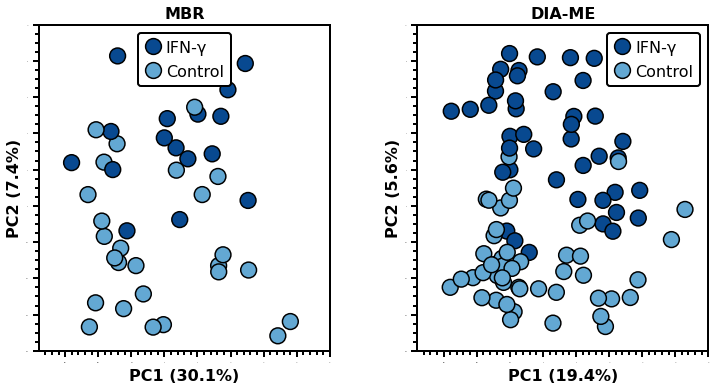

In [89]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
axs = fig.axes
plt.subplots_adjust(wspace=0.3)

for i, frame in enumerate(ifns_i):
    
    pca = PCA(n_components=2).fit_transform(np.log2(frame).T)
    pca = pd.DataFrame(pca, columns=['x','y'])
    
    pca['Experiment'] = frame.columns
    pca['Condition'] = [r.split('_')[3] for r in pca['Experiment']]
    
    sns.scatterplot(data=pca, x='x', y='y', hue='Condition', s=250, palette=[blues[18], blues[10]], 
                    edgecolor='k', linewidth=lw-0.5, ax=axs[i])
    
    axs[i].set_title(names[i], fontsize=fontsize, weight='bold')
    
    for axis in ['top', 'bottom', 'left', 'right']:
        axs[i].spines[axis].set_linewidth(lw)
        
    xvar, yvar = PCA(n_components=2).fit(np.log2(frame).T).explained_variance_ratio_
    axs[i].set_xlabel('PC1 (' + str(round(xvar * 100, 1)) + '%)', weight='bold', fontsize=fontsize, labelpad=6)
    axs[i].set_ylabel('PC2 (' + str(round(yvar * 100, 1)) + '%)', weight='bold', fontsize=fontsize)   
    
    axs[i].minorticks_on()
    axs[i].tick_params(axis='both', which='major', labelsize=0, length=lw*3, width=lw, pad=5)
    axs[i].tick_params(axis='both', which='minor', length=lw*2, width=lw)
    
    axs[i].set_xlim([-19, 25])
    axs[i].set_ylim([-8, 10])
    
    handles = axs[i].get_legend_handles_labels()[0]
    legend = axs[i].legend(handles=handles, labels=labels[::-1], markerscale=1, fontsize=fontsize, handlelength=1, handleheight=1,
                           handletextpad=0.3, labelspacing=0.5, edgecolor='k', framealpha=1, borderpad=0.45, loc=0)
    legend.get_frame().set_linewidth(2)

# plt.savefig('02_Figures/SC_IFN_PCA.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_PCA.pdf', dpi=400, bbox_inches='tight') 

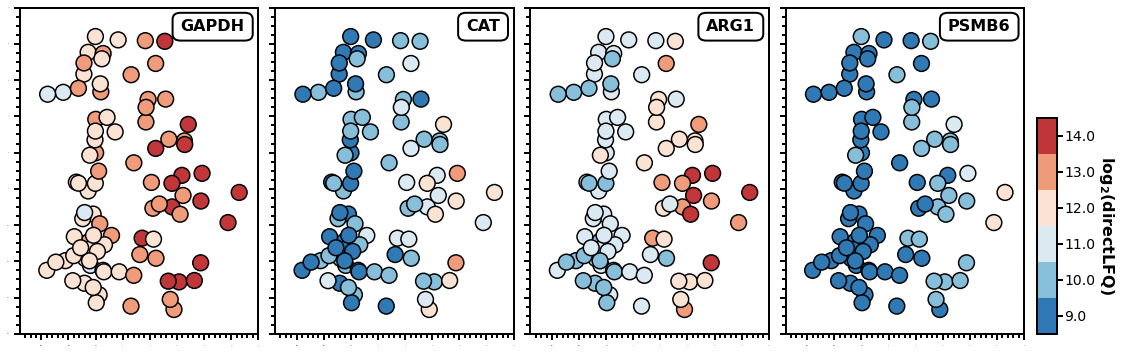

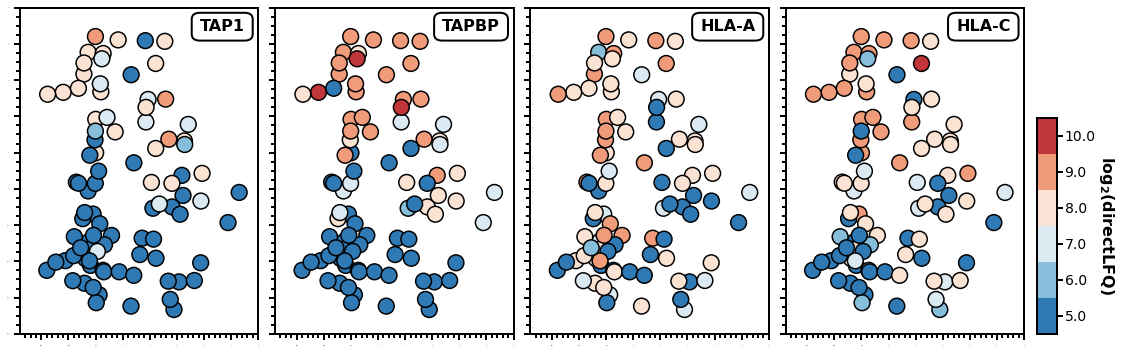

In [90]:
genes1 = ['GAPDH', 'CAT', 'ARG1', 'PSMB6']
genes2 = ['TAP1', 'TAPBP', 'HLA-A', 'HLA-C']

g = np.log2(ifn_i[ifn_i.index.isin(genes1 + genes2)]).T
pca_g = pca.merge(g, how='inner', left_on='Experiment', right_on=g.index) # connecting protein expression with pca (diame)

columns = int(len(g.columns) / 2)

vmins = [9,5]
vmaxs = [15,11]

color_levels = 6
segments = sns.color_palette('RdBu_r', color_levels)
colormap = mpl.colors.ListedColormap(segments)

for i, genes in enumerate([genes1, genes2]):
    
    fig, ax = plt.subplots(1, columns, figsize=(columns*4.5, 6), sharey=True)
    plt.subplots_adjust(wspace=0.07)
    axs = fig.axes
    
    for j in range(len(g[genes].columns)):
        
        sns.scatterplot(data=pca_g, x='x', y='y', c=pca_g[genes[j]], cmap=colormap, vmin=vmins[i], vmax=vmaxs[i], 
                        s=250, linewidth=lw-0.5, edgecolor='k', ax=axs[j])
        
        for axis in ['top', 'bottom', 'left', 'right']:
            axs[j].spines[axis].set_linewidth(lw)
            
        axs[j].minorticks_on()
        axs[j].tick_params(axis='both', which='major', labelsize=0, length=lw*3, width=lw, pad=5)
        axs[j].tick_params(axis='both', which='minor', length=lw*2, width=lw)
        
        axs[j].text(x=22.5, y=8.7, s=genes[j], fontsize=fontsize, fontweight='bold', bbox=props, ha='right')
        
        axs[j].set_xlim([-19, 25])
        axs[j].set_ylim([-8, 10])
        
        axs[j].set_xlabel('')
        axs[j].set_ylabel('')

    bounds = np.arange(vmins[i], vmaxs[i], (vmaxs[i]-vmins[i])/color_levels)
    cmap_img = np.array([bounds]).T

    cax = plt.axes([0.91,0.125,0.015,0.5])
    cax.imshow(cmap_img, cmap=colormap, aspect='auto', origin='lower')
    cax.set_yticks(np.arange(len(segments)))
    cax.set_yticklabels(bounds)
    cax.set_xticks([]) 
    cax.yaxis.set_ticks_position('right')

    cax.tick_params(axis='y', which='major', labelsize=fontsize-2, length=lw*3, width=lw, pad=2)
    cax.set_ylabel('log'+r'$\bf{_{2}}$'+'(directLFQ)', fontsize=fontsize, fontweight='bold', rotation=270, labelpad=-60)

    for axis in ['top', 'bottom', 'left', 'right']:
        cax.spines[axis].set_linewidth(lw)
       
    file_names = ['Ox-Genes', 'IFN-Genes']
#     plt.savefig('02_Figures/SC_IFN_PCA_ProteinExpression_' + file_names[i] + '.png', dpi=400, bbox_inches='tight')
#     plt.savefig('02_Figures/SC_IFN_PCA_ProteinExpression_' + file_names[i] + '.pdf', dpi=400, bbox_inches='tight') 

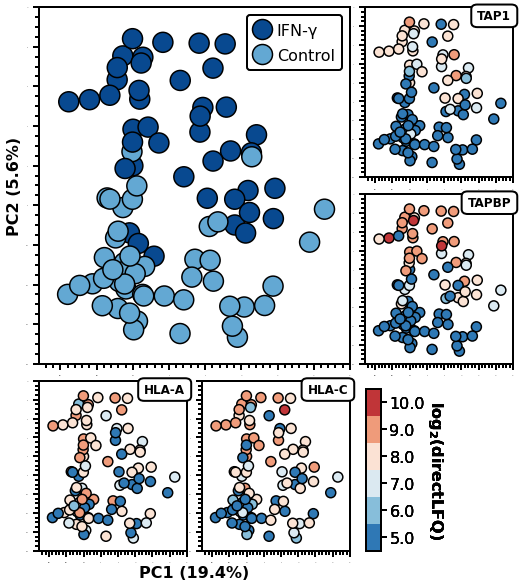

In [91]:
fig, ax = plt.subplot_mosaic([['A', 'A', 'B'],
                              ['A', 'A', 'C'],
                              ['D', 'E', 'F']], figsize=(8.5,10))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
axs = fig.axes
fig.delaxes(axs[5])

sns.scatterplot(data=pca_g, x='x', y='y', hue='Condition', s=400, palette=colors2[::-1], 
                edgecolor='k', linewidth=lw-0.5, ax=axs[0])
        
xvar, yvar = PCA(n_components=2).fit(np.log2(ifns_i[1]).T).explained_variance_ratio_
axs[0].set_xlabel('PC1 (' + str(round(xvar * 100, 1)) + '%)', weight='bold', fontsize=fontsize, labelpad=190)
axs[0].set_ylabel('PC2 (' + str(round(yvar * 100, 1)) + '%)', weight='bold', fontsize=fontsize)   

handles = axs[0].get_legend_handles_labels()[0]
legend = axs[0].legend(handles=handles, labels=labels[::-1], markerscale=1, fontsize=fontsize, handlelength=1, handleheight=1,
                       handletextpad=0.4, labelspacing=0.6, edgecolor='k', framealpha=1, borderpad=0.45, loc=0)
legend.get_frame().set_linewidth(2)
    
# protein expressions subplots
vmin, vmax = 5, 11

color_levels = 6
segments = sns.color_palette('RdBu_r', color_levels)
colormap = mpl.colors.ListedColormap(segments)
    
for i, gene in enumerate(genes):
    
    sns.scatterplot(data=pca_g, x='x', y='y', c=pca_g[gene], cmap=colormap, vmin=vmin, vmax=vmax, 
                        s=100, linewidth=lw-0.5, edgecolor='k', ax=axs[i+1])
    
    axs[i+1].text(x=24.5, y=8.7, s=gene, fontsize=fontsize-4, fontweight='bold', bbox=props, ha='right')
        
    axs[i+1].set_xlabel('')
    axs[i+1].set_ylabel('')

    bounds = np.arange(vmin, vmax, (vmax - vmin) / color_levels)
    cmap_img = np.array([bounds]).T

    cax = plt.axes([0.66,0.125,0.025,0.225])
    cax.imshow(cmap_img, cmap=colormap, aspect='auto', origin='lower')
    cax.set_yticks(np.arange(len(segments)))
    cax.set_yticklabels(bounds)
    cax.set_xticks([]) 
    cax.yaxis.set_ticks_position('right')

    cax.tick_params(axis='y', which='major', labelsize=fontsize, length=lw*3, width=lw, pad=2)
    cax.set_ylabel('log'+r'$\bf{_{2}}$'+'(directLFQ)', fontsize=fontsize, fontweight='bold', rotation=270, labelpad=-60)

    for axis in ['top', 'bottom', 'left', 'right']:
        cax.spines[axis].set_linewidth(lw)

for ax in axs:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(lw)
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=0, length=lw*3, width=lw, pad=5)
    ax.tick_params(axis='both', which='minor', length=lw*2, width=lw)
    
    ax.set_xlim([-18, 25])
    ax.set_ylim([-8, 10])
    
# plt.savefig('02_Figures/SC_IFN_PCA_ProteinExpression_Combined.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_PCA_ProteinExpression_Combined.pdf', dpi=400, bbox_inches='tight')

C:\Users\k689l\AppData\Local\Temp\ipykernel_10504\2537491778.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels)
C:\Users\k689l\AppData\Local\Temp\ipykernel_10504\2537491778.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels)
C:\Users\k689l\AppData\Local\Temp\ipykernel_10504\2537491778.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels)
C:\Users\k689l\AppData\Local\Temp\ipykernel_10504\2537491778.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(labels)
E:\KK\03_Programs\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.canvas.print_figure(

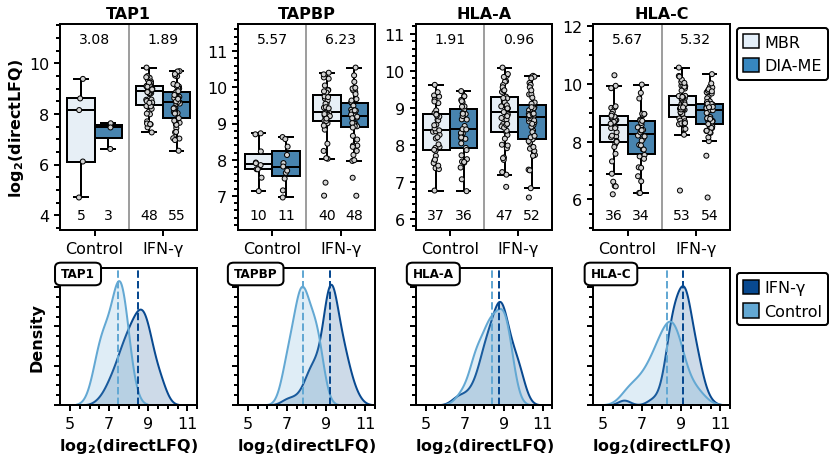

In [92]:
merge = quans[0][quan_cols].merge(quans[1][quan_cols], how='outer', left_index=True, right_index=True)

quan_melt = merge.melt(ignore_index=False).dropna()
quan_melt['Analysis'] = [names[0] if r.endswith('_x') else names[1] for r in quan_melt['variable']]
quan_melt['Condition'] = [r.split('_')[3] for r in quan_melt['variable']]
quan_melt['value'] = np.log2(quan_melt['value'])

fig, ax = plt.subplots(2, 4, figsize=(12,7), gridspec_kw={'height_ratios': [3,2]})
plt.subplots_adjust(wspace=0.3, hspace=0.22)
axs = fig.axes

for ax in axs:
    for axis in ['bottom', 'top', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

for i in range(4):
    
    goi = quan_melt[quan_melt.index.get_level_values(1) == genes2[i]]    
    sns.boxplot(data=goi, x='Condition', y='value', order=['control', 'IFNy'], hue='Analysis', linecolor='k',
                hue_order=['MBR', 'DIA-ME'], showfliers=False, palette=colors, linewidth=lw, ax=axs[i])
    sns.stripplot(data=goi, x='Condition', y='value', order=['control', 'IFNy'], hue='Analysis', edgecolor='k', 
                  hue_order=['MBR', 'DIA-ME'], s=5, palette=['lightgrey', 'lightgrey'], dodge=True, linewidth=lw/2, ax=axs[i])
                  
    axs[i].set_title(genes2[i], fontsize=fontsize, weight='bold')

    ymax = goi['value'].max() + (goi['value'].max() - goi['value'].min()) / 3
    ymin = goi['value'].min() - (goi['value'].max() - goi['value'].min()) / 4
    axs[i].set_ylim(ymin, ymax)
    
    y_pval = ymax - (goi['value'].max() - goi['value'].min()) / 7
    y_num = ymin + (goi['value'].max() - goi['value'].min()) / 12
    
    for j, analysis in enumerate(names):
        frame = goi[goi['Analysis'] == analysis]
        frame_ifn = frame[frame['Condition'] == 'IFNy']
        frame_con = frame[frame['Condition'] == 'control']
        
        pvalue = stat.ttest_ind(list(frame_ifn['value']), list(frame_con['value']))[1]
        log_pval = round(-1*np.log10(pvalue), 2)
        
        axs[i].text(x=j, y=y_pval, s=str(log_pval), fontsize=fontsize-2, ha='center')
        axs[i].text(x=(-0.2+0.4*j), y=y_num, s=len(frame_con), fontsize=fontsize-2, ha='center')
        axs[i].text(x=(0.8+0.4*j), y=y_num, s=len(frame_ifn), fontsize=fontsize-2, ha='center')
            
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_xticklabels(labels)
    axs[i].minorticks_on()
    axs[i].tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize)
    axs[i].tick_params(axis='y', which='minor', pad=5, length=lw*2, width=lw)
    axs[i].tick_params(axis='x', which='minor', length=0)
    axs[i].axvline(x=0.5, color='grey', lw=lw-0.5)
    axs[i].get_legend().remove()
    
    pa1 = mpl.patches.Patch(facecolor=colors[0], edgecolor='k', lw=1.5)
    pa2 = mpl.patches.Patch(facecolor=colors[1], edgecolor='k', lw=1.5)
    handles = [pa1, pa2]

    legend = axs[3].legend(handles=handles, labels=names, handlelength=1, handleheight=1, handletextpad=0.3, 
                           fontsize=fontsize, framealpha=1, edgecolor='k', loc=(1.05,0.73))
    legend.get_frame().set_linewidth(lw)      


    goi = goi[goi['Analysis'] == 'DIA-ME']
    handles = []
    for j, cond in enumerate(goi['Condition'].unique()):
        data = goi[goi['Condition'] == cond]
        sns.kdeplot(data=data, x='value', fill=True, color=colors2[::-1][j], lw=lw, alpha=0.2, ax=axs[i+4])
        handles.append(mpl.patches.Patch(facecolor=colors2[::-1][j], edgecolor='k', lw=1.5))
        
        axs[i+4].axvline(x=data['value'].median(), color=colors2[::-1][j], lw=lw, linestyle='dashed')
        
    axs[i+4].text(x=5.4, y=0.65, s=genes2[i], ha='center', fontsize=fontsize-4, weight='bold', bbox=props)      
    axs[i+4].set_xlabel('log'+r'$\bf{_{2}}$'+'(directLFQ)', fontsize=fontsize, weight='bold', labelpad=5)  
    axs[i+4].set_ylabel('')
    axs[i+4].set_ylim([0,0.7])
    axs[i+4].set_yticklabels([])
    axs[i+4].set_xlim([4.5,11.5])
    axs[i+4].set_xticks([5,7,9,11])
    axs[i+4].minorticks_on()
    axs[i+4].tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize)
    axs[i+4].tick_params(axis='both', which='minor', pad=5, length=lw*2, width=lw)
    
axs[0].set_ylabel('log'+r'$\bf{_{2}}$'+'(directLFQ)', fontsize=fontsize, weight='bold', labelpad=3)
axs[4].set_ylabel('Density', fontsize=fontsize, weight='bold', labelpad=5)

legend = axs[7].legend(handles=handles, labels=labels[::-1], handlelength=1, handleheight=1, handletextpad=0.3, 
                       fontsize=fontsize, framealpha=1, edgecolor='k', loc=(1.05, 0.58))
legend.get_frame().set_linewidth(lw)

# plt.savefig('02_Figures/SC_IFN_ProteinExpression_Boxplots.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_ProteinExpression_Boxplots.pdf', dpi=400, bbox_inches='tight')

In [93]:
medians = pd.DataFrame()
quan_vals = []

diame = quans_f[1]

conditions = ['control', 'IFNy']
for i in range(2):
    cond_cols = [c for c in diame if conditions[i] in c]
    medians[conditions[i]] = np.log2(diame[cond_cols].median(axis=1))
    quan_vals.append(diame[cond_cols].to_numpy(dtype=float))

vdata = pd.DataFrame()
vdata['log fold ifn'] = medians[conditions[1]].sub(medians[conditions[0]])

pvals = []
for row in range(medians.shape[0]):
    ttest_result = stat.ttest_ind(quan_vals[1][row, :], quan_vals[0][row, :], nan_policy='omit')
    pvals.append(ttest_result[1])

vdata['p-val ifn'] = list(np.array(pvals))
vdata['log p-val ifn'] = -1*np.log10(vdata['p-val ifn'])
     
rank = vdata['p-val ifn'].rank()
padj = vdata['p-val ifn'] * rank.max() / rank
vdata['log padj ifn'] = -1*np.log10(padj)

vdata['IFN_Database'] = diame['IFN_Database']
vdata['without ME'] = ['+' if protein in set(quans[0].index.get_level_values(0)) else ''
                       for protein in vdata.index.get_level_values(0)]

path5 = '01_Data/05_Exports/'
# vdata.to_csv(path5 + 'SC_ifn_vdata.tsv', sep='\t')

E:\KK\03_Programs\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:1077: RuntimeWarning: divide by zero encountered in true_divide
  denom = ma.sqrt(svar*(1.0/n1 + 1.0/n2))  # n-D computation here!
C:\Users\k689l\AppData\Local\Temp\ipykernel_10504\2981822234.py:20: UserWarning: Warning: converting a masked element to nan.
  vdata['p-val ifn'] = list(np.array(pvals))


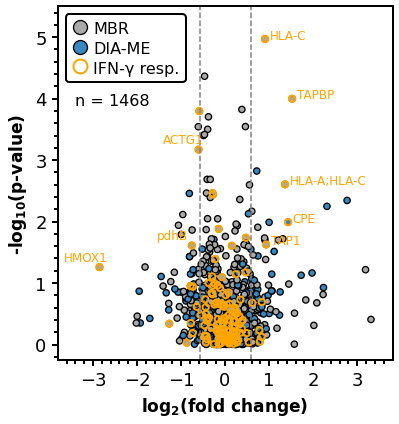

In [94]:
ifn = vdata[vdata['IFN_Database'] != '']

ifn_color = 'orange'
fig, ax = plt.subplots(1, 1, figsize=(6, 6.5))

sns.scatterplot(data=vdata, x='log fold ifn', y='log p-val ifn', hue='without ME', palette=['darkgrey', blues[13]],
                s=40, alpha=1, edgecolor='k', linewidth=1.3, ax=ax)
sns.scatterplot(data=ifn, x='log fold ifn', y='log p-val ifn', facecolor='none', s=40, 
                alpha=1, edgecolor=ifn_color, linewidth=2, ax=ax)

for axis in ['top', 'bottom', 'left', 'right']:
    ax.spines[axis].set_linewidth(lw)
        
ax.set_ylim(ymax=5.5)
ax.set_xlim([-3.8, 3.8])
ax.set_xticks([-3, -2, -1, 0, 1, 2, 3])

ax.axvline(0.58, ymin=0, ymax=14, color='grey', linestyle='dashed', linewidth=lw-0.5)
ax.axvline(-0.58, ymin=0, ymax=14, color='grey', linestyle='dashed', linewidth=lw-0.5)

ax.minorticks_on()
ax.tick_params(axis='both', which='major', labelsize=fontsize+2, length=lw*3, width=lw, pad=5)
ax.tick_params(axis='both', which='minor', length=lw*2, width=lw, pad=5)
    
ax.set_xlabel('log'+r'$\bf{_{2}}$'+'(fold change)', fontsize=fontsize+1, weight='bold', labelpad=6)
ax.set_ylabel(ylabel='-log'+r'$\bf{_{10}}$'+'(p-value)', fontsize=fontsize+1, weight='bold', labelpad=6)  

handles = [mpl.lines.Line2D([0], [0], lw=0, marker='o', color='k', markerfacecolor='darkgrey', 
                            markersize=14, markeredgewidth=1.3),
           mpl.lines.Line2D([0], [0], lw=0, marker='o', color='k', markerfacecolor=blues[13], 
                            markersize=14, markeredgewidth=1.3),
           mpl.lines.Line2D([0], [0], lw=0, marker='o', color=ifn_color, markerfacecolor='none', 
                            markersize=14, markeredgewidth=2)]

legend = ax.legend(handles=handles, labels=['MBR', 'DIA-ME', interferon + ' resp.'], fontsize=fontsize,
                   handlelength=1, handleheight=1, handletextpad=0.3, labelspacing=0.25, edgecolor='k', 
                   framealpha=1, borderpad=0.4, loc=2)
legend.get_frame().set_linewidth(lw)

ax.text(-3.4, 3.9, 'n = ' + str(len(vdata)), fontsize=fontsize)

for i in range(ifn.shape[0]):
    if ifn['log fold ifn'][i] > 0.6 and ifn['log p-val ifn'][i] > 1:
        ax.text(x=ifn['log fold ifn'][i]+0.1, y=ifn['log p-val ifn'][i], s=ifn['IFN_Database'][i], 
                fontsize=fontsize-4, color=ifn_color)
    if ifn['log fold ifn'][i] < -0.6 and ifn['log p-val ifn'][i] > 1:
        ax.text(x=ifn['log fold ifn'][i]-0.8, y=ifn['log p-val ifn'][i]+0.1, s=ifn['IFN_Database'][i], 
                fontsize=fontsize-4, color=ifn_color)
        
# plt.savefig('02_Figures/SC_IFN_Volcano.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_Volcano.pdf', dpi=400, bbox_inches='tight')

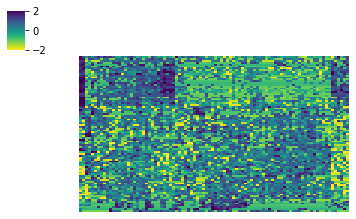

In [95]:
cluster_frame = []

for i in range(len(ifns_f[1])):
    
    min_value = np.log2(ifns_f[1]).iloc[i].min() - 1
    cluster_frame.append(np.log2(ifns_f[1]).iloc[i].replace(np.nan, min_value))
    
cluster_frame = pd.DataFrame(cluster_frame)

vmin, vmax = -2, 2
cluster = sns.clustermap(cluster_frame, metric='euclidean', z_score=0, figsize=(5,3), col_cluster=True, cmap=cmap, 
                         vmin=vmin, vmax=vmax, xticklabels=False, yticklabels=False)
cluster.ax_row_dendrogram.set_visible(False)
cluster.ax_col_dendrogram.set_visible(False)

new_index = cluster_frame.index[cluster.dendrogram_row.reordered_ind]
new_cols = cluster_frame.columns[cluster.dendrogram_col.reordered_ind]
clustered = cluster_frame.loc[new_index, new_cols].drop_duplicates()

for i in range(len(clustered)):
    mean = clustered.iloc[i].mean()
    std = clustered.iloc[i].std()
    clustered.iloc[i] = clustered.iloc[i].sub(mean).div(std)

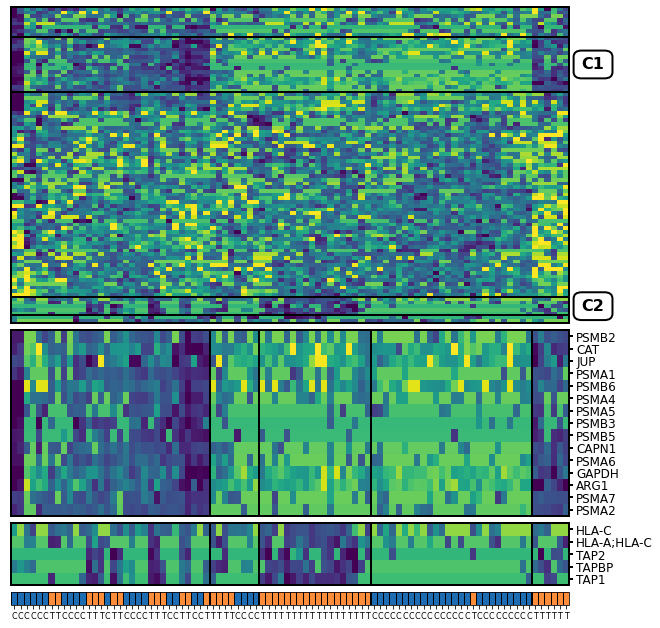

In [96]:
c1_top, c1_bot = 8, 23
c2_top, c2_bot = 78, 83

cluster1 = clustered.iloc[c1_top:c1_bot]
cluster2 = clustered.iloc[c2_top:c2_bot]

fig, ax = plt.subplots(4,1, figsize=(10, 11), 
                       gridspec_kw={'height_ratios': [len(cluster1)*1.7,len(cluster1),len(cluster2),1]})
plt.subplots_adjust(hspace=0.05)
axs = fig.axes

sns.heatmap(clustered, cmap=cmap, vmin=vmin, vmax=vmax, cbar=None, xticklabels=False, yticklabels=False, ax=axs[0])

for i in [c1_top, c1_bot, c2_top, c2_bot]:
    axs[0].axhline(y=i, lw=lw, color='k')
    
sns.heatmap(cluster1, cmap=cmap, vmin=vmin, vmax=vmax, cbar=None, xticklabels=False, ax=axs[1])
sns.heatmap(cluster2, cmap=cmap, vmin=vmin, vmax=vmax, cbar=None, xticklabels=False, ax=axs[2])

for ax in axs:
    
    for axis in ['bottom', 'top', 'left', 'right']:
        ax.spines[axis].set_visible(True)
        ax.spines[axis].set_linewidth(2) 
        
    ax.tick_params(axis='y', which='major', pad=3, length=lw*2, width=lw, labelsize=fontsize-4)

for i, cluster in enumerate([cluster1, cluster2]):
    axs[i+1].yaxis.set_ticks_position('right')
    axs[i+1].yaxis.set_label_position('right')
    axs[i+1].set_yticklabels(cluster.index, rotation=0)
    
axs[0].text(x=len(clustered.columns)+2, y=(c1_top + c1_bot)/2, va='center', s='C1', 
            weight='bold', fontsize=fontsize, bbox=props)
axs[0].text(x=len(clustered.columns)+2, y=(c2_top + c2_bot)/2, va='center', s='C2', 
            weight='bold', fontsize=fontsize, bbox=props)
# axs[1].text(x=len(clustered.columns)+2, y=len(cluster1)/2, va='center', s='C1', 
#             weight='bold', fontsize=fontsize, bbox=props)
# axs[2].text(x=len(clustered.columns)+2, y=len(cluster2)/2, va='center', s='C2', 
#             weight='bold', fontsize=fontsize, bbox=props)

new_ticks = []
for col in clustered.columns:  
    if 'control' in col:
        new_ticks.append('C')
    if 'IFNy' in col:
        new_ticks.append('T')

color_dict = {'C': blues[15], 'T': oranges[2]}
# color_dict = {'C': colors2[0], 'T': colors2[1]}

color_ticks = [color_dict[tick] for tick in new_ticks]
colormap = mpl.colors.ListedColormap(color_ticks)
bounds = list(range(len(color_ticks)+1))
norm = mpl.colors.BoundaryNorm(bounds, colormap.N)

cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), orientation='horizontal', cax=axs[3])
axs[3].set_xticks(np.arange(0.5, len(clustered.columns), 1))
axs[3].set_xticklabels(new_ticks, rotation=0, fontsize=8)

for i in range(len(new_ticks)):
    axs[3].axvline(x=i, color='k', lw=lw/2)

for ax in axs[1:4]:
    ax.axvline(x=32, lw=lw, color='k')
    ax.axvline(x=40, lw=lw, color='k')
    ax.axvline(x=58, lw=lw, color='k')
    ax.axvline(x=84, lw=lw, color='k')
    
# plt.savefig('02_Figures/SC_IFN_ClusterAnalysis.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_ClusterAnalysis.pdf', dpi=400, bbox_inches='tight')

E:\KK\03_Programs\Anaconda3\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


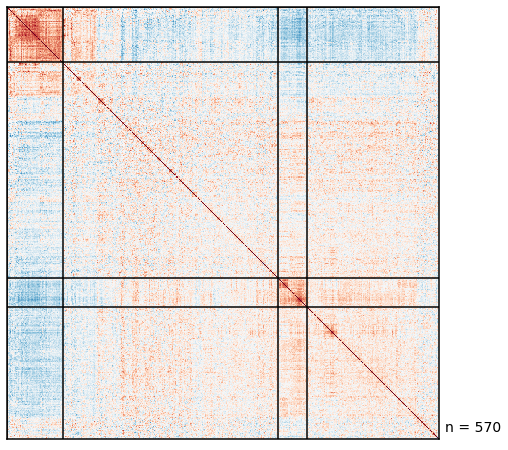

In [97]:
valid_values = 0.3

frame = quans[1][quans[1]['Potential contaminants'].isna()]
frame = np.log2(frame[quan_cols]).dropna(thresh=round(len(quan_cols))*valid_values)
frame = frame[~frame.index.get_level_values(1).str.contains(';')]   # only unique proteins

pearson = frame.T.corr(min_periods=20).replace(np.nan, 0)  # present in at least 20 cells

cluster = sns.clustermap(pearson, metric='euclidean', z_score=None, figsize=(8,8), vmin=-1, vmax=1,
                         cmap=cmap2, xticklabels=False, yticklabels=False)
heatmap = cluster.ax_heatmap

cluster.cax.set_visible(False)
cluster.ax_row_dendrogram.set_visible(False)
cluster.ax_col_dendrogram.set_visible(False)

heatmap.set_xlabel('')
heatmap.set_ylabel('')

for axis in ['top', 'bottom', 'left', 'right']:
    heatmap.spines[axis].set_visible(True)
    heatmap.spines[axis].set_linewidth(lw-0.5)
    
heatmap.text(x=len(pearson)+8, y=len(pearson)-10, s='n = '+str(len(pearson)), fontsize=fontsize-2)

new_index = pearson.index[cluster.dendrogram_row.reordered_ind]
new_cols = pearson.columns[cluster.dendrogram_col.reordered_ind]
clustered = pearson.loc[new_index, new_cols]

c1_bot, c1_top = 0, 73
c2_bot, c2_top = 357, 395

for i in [c1_bot, c1_top, c2_bot, c2_top]:
    heatmap.axvline(x=i, color='k', linewidth=lw-0.5)
    heatmap.axhline(y=i, color='k', linewidth=lw-0.5)

c1 = pd.DataFrame(clustered.iloc[c1_bot:c1_top].index.get_level_values(1))
c2 = pd.DataFrame(clustered.iloc[c2_bot:c2_top].index.get_level_values(1)) 
c1.to_csv(path5 + 'Protein_Correlations_Cluster1.tsv', sep='\t')
c2.to_csv(path5 + 'Protein_Correlations_Cluster2.tsv', sep='\t')

corr_clusters = pd.concat([clustered.iloc[c1_bot:c1_top].sort_index(level='Genes'), 
                           clustered.iloc[c2_bot:c2_top].sort_index(level='Genes')])
corr_clusters = corr_clusters[corr_clusters.index]

# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_all.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_all.pdf', dpi=400, bbox_inches='tight')

Text(858.23, 0.5, 'Pearson Correlation')

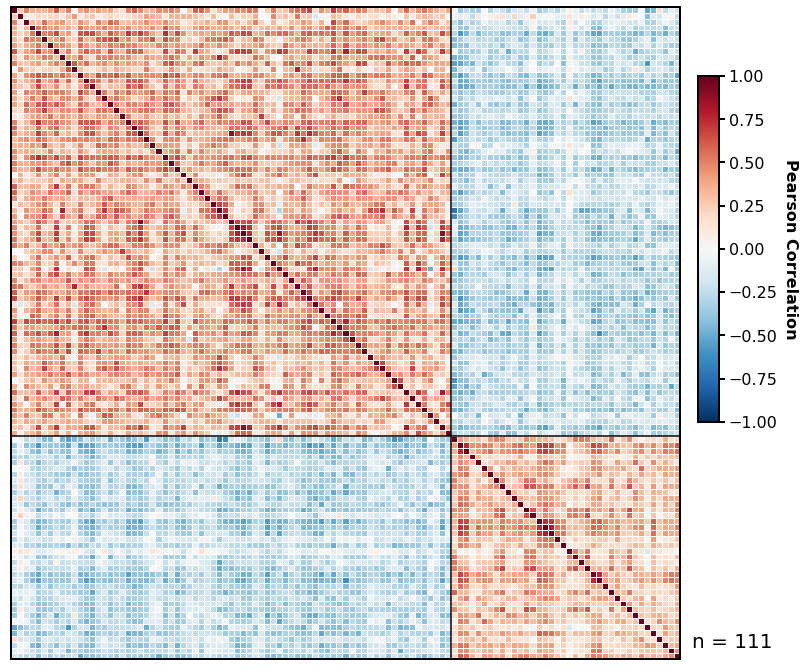

In [98]:
fig, ax = plt.subplots(1,1, figsize=(12,12))

cbar = plt.axes([0.92,0.4,0.025, 0.4])
sns.heatmap(corr_clusters, cmap=cmap2, linewidth=1, vmin=-1, vmax=1, 
            xticklabels=False, yticklabels=False, ax=ax, cbar_ax=cbar)

ax.set_xlabel('')
ax.set_ylabel('')

ax.axhline(y=c1_top, color='k')
ax.axvline(x=c1_top, color='k')

ax.text(x=len(corr_clusters)+2, y=len(corr_clusters)-2, s='n = '+str(len(corr_clusters)), fontsize=fontsize+4)

for ax in [ax, cbar]:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_visible(True)
        ax.spines[axis].set_linewidth(2)
        
cbar.tick_params(axis='y', which='major', length=lw*3, width=lw, labelsize=fontsize)
cbar.set_ylabel('Pearson Correlation', fontsize=fontsize, weight='bold', rotation=270, labelpad=20)

# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_Clusters.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_Clusters.pdf', dpi=400, bbox_inches='tight')

Text(0, 1.15, 'Pearson')

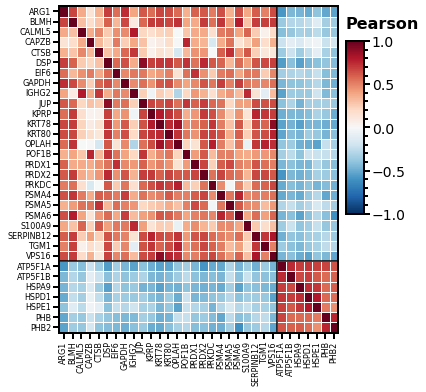

In [99]:
min_corr = 0.729
max_corr = -0.729

high_corr = corr_clusters[(corr_clusters > min_corr) | (corr_clusters < max_corr)]  # select highest correlations
high_corr = high_corr.replace(1,np.nan).dropna(how='all').dropna(how='all', axis=1)
high_corr = corr_clusters.loc[high_corr.index][high_corr.index]  # get correlations among highest correlated proteins

fig, ax = plt.subplots(1,1, figsize=(5,6))

cbar = plt.axes([0.92,0.4,0.05, 0.4])
sns.heatmap(high_corr, cmap=cmap2, linewidth=1, ax=ax, cbar_ax=cbar, vmin=-1, vmax=1,
            xticklabels=high_corr.columns.get_level_values(1),
            yticklabels=high_corr.index.get_level_values(1))

ax.set_xlabel('')
ax.set_ylabel('')
ax.tick_params(axis='both', which='major', pad=2, length=lw*3, width=lw, labelsize=fontsize/2)

cbar.minorticks_on()
cbar.tick_params(axis='y', which='major', pad=2, length=lw*3, width=lw, labelsize=fontsize-2)
cbar.tick_params(axis='y', which='minor', length=lw*2, width=lw)

ax.axhline(y=25, color='black')
ax.axvline(x=25, color='black')

for ax in [ax, cbar]:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_visible(True)
        ax.spines[axis].set_linewidth(2)

    ax.tick_params()

cbar.text(x=0, y=1.15, s='Pearson', fontsize=fontsize, weight='bold')

# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_Highest.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_Highest.pdf', dpi=400, bbox_inches='tight')

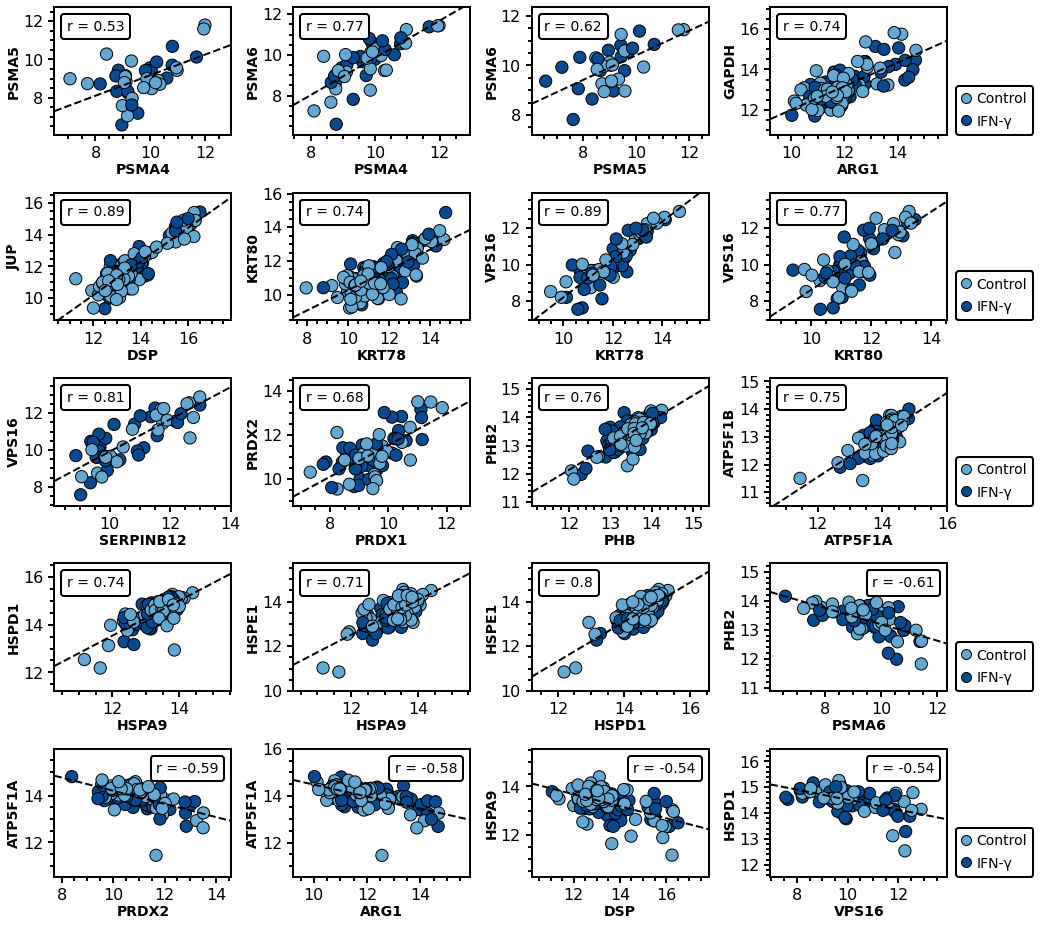

In [100]:
gene_combis = [('PSMA4', 'PSMA5'), ('PSMA4', 'PSMA6'), ('PSMA5', 'PSMA6'), ('ARG1', 'GAPDH'),
               ('DSP', 'JUP'), ('KRT78', 'KRT80'), ('KRT78', 'VPS16'), ('KRT80', 'VPS16'),
               ('SERPINB12', 'VPS16'), ('PRDX1', 'PRDX2'), ('PHB', 'PHB2'), ('ATP5F1A', 'ATP5F1B'),
               ('HSPA9', 'HSPD1'), ('HSPA9', 'HSPE1'), ('HSPD1', 'HSPE1'), ('PSMA6', 'PHB2'),
               ('PRDX2', 'ATP5F1A'), ('ARG1', 'ATP5F1A'), ('DSP', 'HSPA9'), ('VPS16', 'HSPD1')]
size = 150
cols = 4
rows = 5

diame_melt = quan_melt[quan_melt['Analysis'] == 'DIA-ME'].drop(columns='Analysis')

fig, ax = plt.subplots(rows, cols, figsize=(cols*4, rows*3.2))
plt.subplots_adjust(wspace=0.35, hspace=0.45)
axs = fig.axes

for ax in axs:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(2)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', pad=5, length=lw*2, width=lw)

for i in range(rows):
    
    cp1 = mpl.lines.Line2D([0], [0], marker='o', color='k', markerfacecolor=colors2[0], markersize=10)
    cp2 = mpl.lines.Line2D([0], [0], marker='o', color='k', markerfacecolor=colors2[1], markersize=10)
    
    legend = axs[cols*(i+1)-1].legend(handles=[cp1, cp2], labels=['Control', interferon], 
                 fontsize=fontsize-2, handlelength=0.5, handleheight=1, handletextpad=0.5, 
                 labelspacing=0.6, edgecolor='k', framealpha=1, borderpad=0.45, loc=(1.05,0)) 
    axs[cols*(i+1)-1].add_artist(legend)
    legend.get_frame().set_linewidth(lw)  
    
for i in range(len(gene_combis)):
    
    goi_x = diame_melt[diame_melt.index.get_level_values(1) == gene_combis[i][0]]
    goi_y = diame_melt[diame_melt.index.get_level_values(1) == gene_combis[i][1]]
    goi = goi_x.merge(goi_y, right_on='variable', left_on='variable')

    x, y = goi['value_x'], goi['value_y']

    sns.scatterplot(data=goi, x=x, y=y, hue='Condition_x', hue_order=['control', 'IFNy'], 
                    palette=colors2, edgecolor='k', s=size, ax=axs[i])

    r = pearson.xs(gene_combis[i][0], level='Genes').xs(gene_combis[i][1], level='Genes', axis=1)
    slope = r * (np.std(y) / np.std(x))
    intercept = np.mean(y) - slope * np.mean(x)
    
    axs[i].axline((0,intercept.values[0][0]), slope=slope.values[0][0], linestyle='dashed', lw=lw, color='k', zorder=2)

    axs[i].set_xlim([x.min()*0.92, x.max()*1.08])
    axs[i].set_ylim([y.min()*0.92, y.max()*1.08])
    
    axs[i].set_xlabel(gene_combis[i][0], fontsize=fontsize-2, weight='bold', labelpad=2)
    axs[i].set_ylabel(gene_combis[i][1], fontsize=fontsize-2, weight='bold', labelpad=2)
    axs[i].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True, nbins=5))
    axs[i].yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True, nbins=5))
    
    axs[i].get_legend().remove()
    pa = mpl.lines.Line2D([0], [0], marker='o', color='k', markersize=0)
    legend = axs[i].legend(handles=[pa], labels=['r = '+str(round(r.values[0][0],2))], handlelength=0, handletextpad=0,
             fontsize=fontsize-2, edgecolor='k', framealpha=1, loc=0)
    legend.get_frame().set_linewidth(lw)             

# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_Scatters.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_Scatters.pdf', dpi=400, bbox_inches='tight')

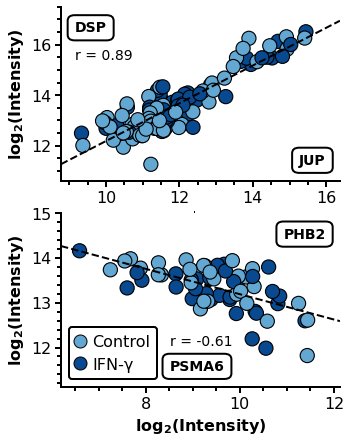

In [101]:
gene_combis = [('JUP', 'DSP'), 
               ('PSMA6', 'PHB2')]
size = 200

fig, ax = plt.subplots(2, 1, figsize=(5,7))
plt.subplots_adjust(hspace=0.18)
axs = fig.axes

for ax in axs:
    
    for axis in ['top', 'right']:
        ax.spines[axis].set_visible(False)
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2)

    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', length=lw*3, width=lw, labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', length=lw*2, width=lw)

for i in range(len(gene_combis)):
    
    goi_x = diame_melt[diame_melt.index.get_level_values(1) == gene_combis[i][0]]
    goi_y = diame_melt[diame_melt.index.get_level_values(1) == gene_combis[i][1]]
    goi = goi_x.merge(goi_y, right_on='variable', left_on='variable')

    x, y = goi['value_x'], goi['value_y']

    sns.scatterplot(data=goi, x=x, y=y, hue='Condition_x', hue_order=['control', 'IFNy'], 
                    palette=colors2, edgecolor='k', s=size, ax=axs[i])

    r = pearson.xs(gene_combis[i][0], level='Genes').xs(gene_combis[i][1], level='Genes', axis=1)
    slope = r * (np.std(y) / np.std(x))
    intercept = np.mean(y) - slope * np.mean(x)
    
    axs[i].axline((0,intercept.values[0][0]), slope=slope.values[0][0], linestyle='dashed', lw=lw, color='k', zorder=2)

    axs[i].set_xlim([x.min()*0.94, x.max()*1.06])
    axs[i].set_ylim([y.min()*0.94, y.max()*1.06])
    
    axs[i].set_ylabel('log'+r'$\bf{_{2}}$' + '(Intensity)', fontsize=fontsize, weight='bold', labelpad=5)
    axs[i].xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True, nbins=5))
    axs[i].yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True, nbins=5))
    
    axs[i].get_legend().remove()
    
    if i == 0:
        axs[i].text(x=x.min()*0.98, y=y.max(), s=gene_combis[i][1], fontsize=fontsize-2, weight='bold', bbox=props)
        axs[i].text(x=x.max()*0.988, y=y.min(), s=gene_combis[i][0], fontsize=fontsize-2, weight='bold', bbox=props)
        
        axs[i].text(x=x.min()*0.98, y=15.4, s='r = '+str(round(r.values[0][0],2)), fontsize=fontsize-2)
        
    if i == 1:
        axs[i].text(x=x.max()*0.955, y=y.max()*1.02, s=gene_combis[i][1], fontsize=fontsize-2, weight='bold', bbox=props)
        axs[i].text(x=x.min()*1.29, y=y.min()*0.972, s=gene_combis[i][0], fontsize=fontsize-2, weight='bold', bbox=props)
        
        axs[i].text(x=x.min()*1.29, y=12.05, s='r = '+str(round(r.values[0][0],2)), fontsize=fontsize-2)

axs[1].set_xlabel('log'+r'$\bf{_{2}}$' + '(Intensity)', fontsize=fontsize, weight='bold', labelpad=5)    
        
cp1 = mpl.lines.Line2D([0], [0], marker='o', color='k', markerfacecolor=colors2[0], markersize=13)
cp2 = mpl.lines.Line2D([0], [0], marker='o', color='k', markerfacecolor=colors2[1], markersize=13)
    
legend = axs[1].legend(handles=[cp1, cp2], labels=['Control', interferon],
                       fontsize=fontsize, handlelength=0.5, handleheight=1, handletextpad=0.5, 
                       labelspacing=0.4, edgecolor='k', framealpha=1, borderpad=0.45, loc=3) 
legend.get_frame().set_linewidth(lw)  
    
# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_Scatters_Pairs.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_Scatters_Pairs.pdf', dpi=400, bbox_inches='tight') 

Text(385.55, 0.5, 'Pearson Correlation')

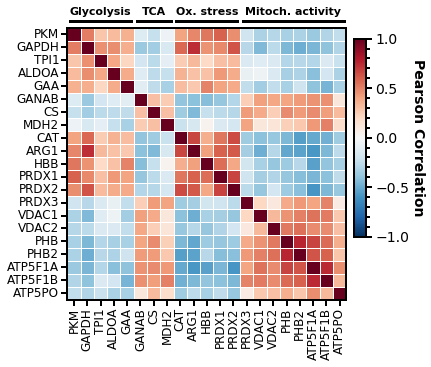

In [102]:
oxo = ['CAT', 'ARG1', 'HBB', 'PRDX1', 'PRDX2']
mito = ['PRDX3', 'VDAC1', 'VDAC2', 'PHB', 'PHB2', 'ATP5F1A', 'ATP5F1B', 'ATP5PO']
glyko = ['PKM', 'GAPDH', 'TPI1', 'ALDOA', 'GAA']
tca = ['GANAB', 'CS', 'MDH2']

corr = corr_clusters.droplevel('Protein.Group').droplevel('Protein.Group', axis=1)
corr = corr[glyko + tca + oxo + mito].loc[glyko + tca + oxo + mito]

fig, ax = plt.subplots(1,1, figsize=(5,5))
    
cax = plt.axes([0.92,0.3,0.035, 0.55])
sns.heatmap(data=corr, cmap=cmap2, linewidth=1, vmax=1, vmin=-1, cbar_ax=cax, ax=ax)
    
ax.set_xlabel('')
ax.set_ylabel('')
    
ax.tick_params(axis='both', which='major', length=lw*3, width=lw, labelsize=fontsize-4, pad=2)
   
groups = ['Glycolysis', 'TCA', 'Ox. stress', 'Mitoch. activity']
counter = 0
for i, group in enumerate([glyko, tca, oxo, mito]):
    length = len(group) / len(corr)
    ax.axhline(xmin=counter+0.01, xmax=counter+length-0.01, y=-0.5, color='k', lw=lw*1.5, clip_on=False)
    xpos = counter*len(corr)+(length*len(corr)/2)
    ax.text(x=xpos, y=-1, s=groups[i], fontsize=fontsize-5, weight='bold', ha='center')
    counter += length
    
for ax in [ax, cax]:
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_visible(True)
        ax.spines[axis].set_linewidth(2)

cax.minorticks_on()
cax.tick_params(axis='y', which='major', length=lw*3, width=lw, labelsize=fontsize-2)
cax.tick_params(axis='y', which='minor', length=lw*2, width=lw)
cax.set_yticks([-1,-0.5,0,0.5,1])
cax.set_ylabel('Pearson Correlation', fontsize=fontsize-2, weight='bold', rotation=270, labelpad=15)

# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_Glycolysis.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_Glycolysis.pdf', dpi=400, bbox_inches='tight') 

E:\KK\03_Programs\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.canvas.print_figure(bytes_io, **kw)
E:\KK\03_Programs\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.canvas.print_figure(bytes_io, **kw)
E:\KK\03_Programs\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  fig.canvas.print_figure(bytes_io, **kw)
E:\KK\03_Programs\Anaconda3\lib\site-packages\IPython\core\pylab

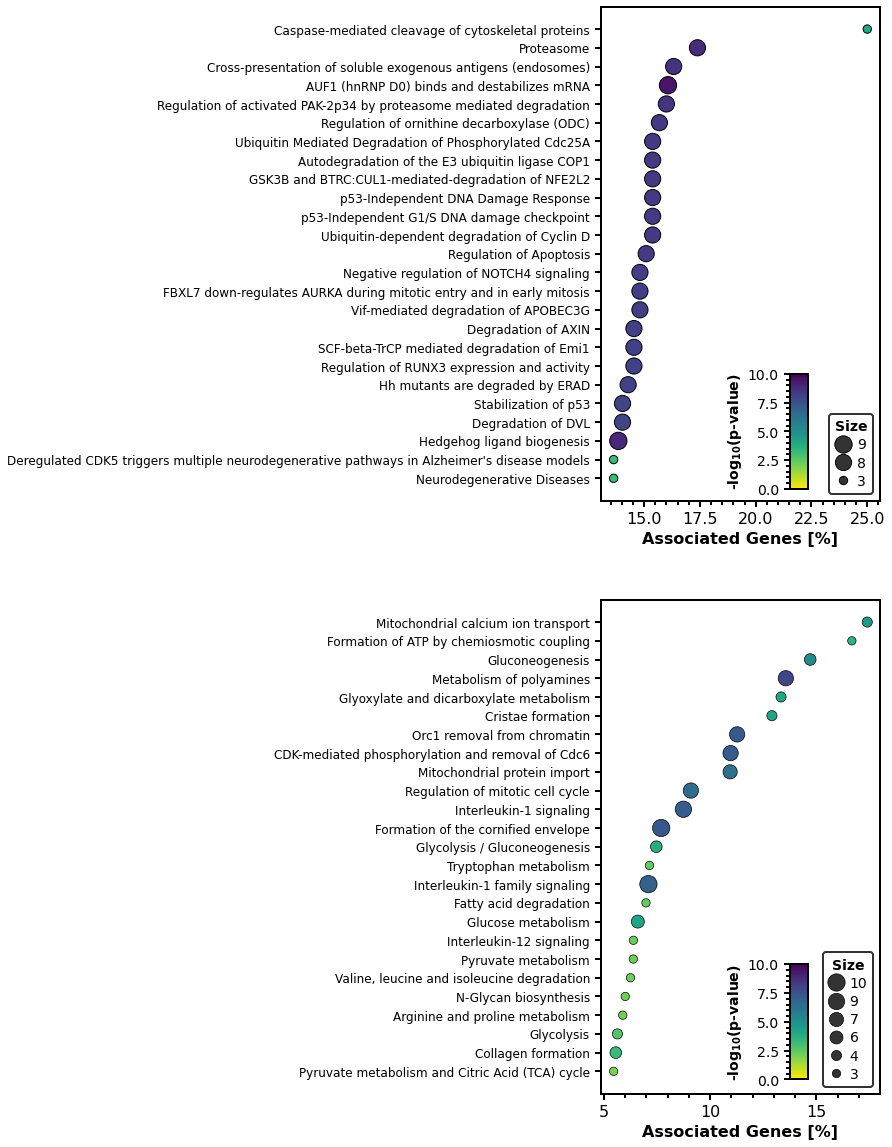

In [103]:
# overrepresentation analysis of pearson correlation clusters

path6 = '01_Data/06_Enrichments/'
c1 = pd.read_csv(path6 + 'GSEA_cluster1.csv')
c2 = pd.read_csv(path6 + 'GSEA_cluster2.csv')

c1['log pvalue'] = -np.log10(c1['Term PValue'])
c2['log pvalue'] = -np.log10(c2['Term PValue'])

c1 = c1[c1['% Associated Genes'] > 13.6].sort_values(by='% Associated Genes', ascending=False)
c2 = c2[c2['% Associated Genes'] > 5.4].sort_values(by='% Associated Genes', ascending=False)

enrichments = [c1, c2]

fig, ax = plt.subplots(2,1, figsize=(5,20))
plt.subplots_adjust(hspace=0.2)
axs = fig.axes

for i in range(2):

    sns.scatterplot(data=enrichments[i], x='% Associated Genes', y='Term', hue='log pvalue', hue_norm=(0,10),
                    size='Nr. Genes', sizes=(70,300), edgecolor='k', palette=cmap, ax=axs[i])
    
    axs[i].set_ylabel('')
    axs[i].set_xlabel('Associated Genes [%]', fontsize=fontsize, weight='bold', labelpad=5)

    for axis in ['top', 'bottom', 'left', 'right']:
        axs[i].spines[axis].set_linewidth(lw)

    axs[i].minorticks_on()
    axs[i].tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize)
    axs[i].tick_params(axis='y', labelsize=fontsize-4)
    
    axs[i].tick_params(axis='x', which='minor', length=lw*2, width=lw)
    axs[i].tick_params(axis='y', which='minor', length=0)
    
# plot colormap
colormap = plt.get_cmap(cmap)
norm = mpl.colors.Normalize(vmin=0, vmax=10)
sm = mpl.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])  

cax1 = fig.add_axes([0.65,0.545,0.05,0.08])
cax2 = fig.add_axes([0.65,0.135,0.05,0.08])

cbar1 = plt.colorbar(sm, cax=cax1)
cbar2 = plt.colorbar(sm, cax=cax2)

for ax in [cax1, cax2]:
    
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_visible(True)
        ax.spines[axis].set_linewidth(lw)
        
    ax.yaxis.set_label_position('left')
    ax.yaxis.tick_left()

    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', pad=5, length=lw*3, width=lw, labelsize=fontsize-2)
    ax.tick_params(axis='both', which='minor', pad=5, length=lw*2, width=lw)

    ax.set_ylabel('-log'+r'$\bf{_{10}}$' + '(p-value)', weight='bold', fontsize=fontsize-2)
    
handles1, labels1 = axs[0].get_legend_handles_labels()
legend1 = axs[0].legend(handles=handles1[6:30][::-1], fontsize=fontsize-2, markerscale=1, loc=4,
                    handletextpad=0.5, labelspacing=0.3, handlelength=1, edgecolor='k', title='Size')

handles2, labels2 = axs[1].get_legend_handles_labels()
legend2 = axs[1].legend(handles=handles2[7:30][::-1], fontsize=fontsize-2, markerscale=1, loc=4,
                    handletextpad=0.5, labelspacing=0.3, handlelength=1, edgecolor='k', title='Size')

for legend in [legend1, legend2]:
    plt.setp(legend.get_title(), fontsize=fontsize-2, fontweight='bold')
    legend.get_frame().set_linewidth(2)

# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_Cluster_Enrichments.png', dpi=400, bbox_inches='tight')
# plt.savefig('02_Figures/SC_IFN_Pearson_Correlations_Cluster_Enrichments.pdf', dpi=400, bbox_inches='tight') 